# Transporter analysis of bacillus mother-spore

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [130]:
main_mechanisms = [ 'ACKr_REV_BSU29470-MONOMER_s',
                    'PGK_REV_BSU33930-MONOMER_s',
                    'PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s',
                    'PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s']

In [131]:
for r in main_mechanisms:
    sporeme.reactions.get_by_id(r).bounds = (0,0)

In [8]:
version = 'v5_all_KO'

In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 252.627315 seconds
Finished substituting S,lb,ub in 7.449539 seconds
Finished makeME_LP in 1.431293 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 7.480136 seconds


In [ ]:
# with open("./sporeme_solution_v2.pickle", "rb") as outfile:
#     sporeme = pickle.load(outfile)

In [ ]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [ ]:
# Get transport reactions

def get_compartments(r):
    comps = []
    if isinstance(r,cobrame.MetabolicReaction):
        for m in r.metabolites:
            if isinstance(m,cobrame.Metabolite):
                comps.append(m.id[-1])
    return list(set(comps))

def get_all_transport(model):
    transport_reactions = []
    for r in tqdm(model.reactions):
        comps = get_compartments(r)
        if len(comps) > 1 and 's' in comps:
            transport_reactions.append(r.id)
    return list(set(transport_reactions))

def get_active_transport(transport_reactions):
    active_transporters = []
    for r in tqdm(transport_reactions):
        if 'SPONT' not in r and abs(sporeme.solution.x_dict[r])>0.:
            active_transporters.append(r)
    # Include arginine transport
    arginine_transport = [r.id for r in get_transport_reactions(sporeme,'arg__L_c',comps=['c','s'])+get_transport_reactions(sporeme,'arg__L_c',comps=['s','c'])]
    [active_transporters.append(r) for r in arginine_transport]
    active_transporters = list(set(active_transporters))
    return active_transporters

In [ ]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

In [ ]:
count = {'no_rule':0,'spont':0,'annot':0}
for r in transport_reactions:
    if 'dummy' in r:
        count['no_rule']+=1
    elif 'SPONT' in r:
        count['spont']+=1
    else:
        count['annot']+=1
pd.DataFrame.from_dict({'count':count}).plot.bar(figsize=(6,4),legend=False)
plt.ylabel('Count')

In [ ]:
active_transporters = get_active_transport(transport_reactions)

In [ ]:
print('{} active transport reactions identified'.format(len(active_transporters)))

In [ ]:
for r in transport_reactions:
    if r not in active_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [133]:
with open("./sporeme_solution_{}.pickle".format(version), "wb") as outfile:
    pickle.dump(sporeme, outfile)

## Check by group of transporters of metabolite

In [ ]:
with open("./sporeme_solution_{}.pickle".format(version), "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-4,growth_key = 'sigma', verbosity = 2)

In [ ]:
def get_necessary_metabolites(model,active_transporters):
    necessary_metabolites = []
    for r in tqdm(active_transporters):
        rxn = model.reactions.get_by_id(r)
        for m in rxn.products:
            if not isinstance(m,cobrame.Metabolite):
                continue
            met_root = m.id[:-2]
            for i in rxn.reactants:
                if met_root in i.id:
                    necessary_metabolites.append(m.id)
    return list(set(necessary_metabolites))

def get_all_available_transport(model,necessary_metabolites):
    available_transport = []
    at_dict = {}
    for m in tqdm(necessary_metabolites):
        rxns = get_transport_reactions(model,m,comps=['c','s']) + get_transport_reactions(model,m,comps=['s','c'])
        [available_transport.append(r.id) for r in rxns]
        at_dict[m] = []
        [at_dict[m].append(r.id) for r in rxns]
    return list(set(available_transport)), at_dict

In [ ]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [ ]:
transport_reactions = get_all_transport(sporeme)
print('{} transport reactions identified'.format(len(transport_reactions)))

In [ ]:
active_transporters = get_active_transport(transport_reactions)
necessary_metabolites = get_necessary_metabolites(sporeme,active_transporters)
necessary_metabolites.remove('h_s')
necessary_metabolites.remove('h_c')
available_transport, at_dict = get_all_available_transport(sporeme,necessary_metabolites)

In [ ]:
print('{} active transport reactions identified'.format(len(active_transporters)))
print('{} necessary metabolites identified'.format(len(necessary_metabolites)))
print('{} available transport reactions identified'.format(len(available_transport)))

In [ ]:
all_transporters_to_open = list(set(active_transporters + available_transport))
print('{} open transport reactions identified'.format(len(all_transporters_to_open)))
print('Included {}'.format(set(active_transporters)-set(available_transport)))

In [ ]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
# for r in sporeme.reactions:
#     comps = set([m.id[-1] for m,_ in r.metabolites.items() if isinstance(m,cobrame.Metabolite)])
#     if 's' in comps and 'e' in comps:
#         print(r.id,r.reaction,sporeme.solution.x_dict[r.id])

In [ ]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .01, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,necessary_metabolites, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')

In [ ]:
flux_results_df.to_csv('group_KO_flux_results_{}.csv'.format(version))

In [ ]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))
plt.tight_layout()
plt.savefig("group_KO_flux_results_{}.svg".format(version), format="SVG")

### Close metabolite one by one
Including information about arginine being transported

In [ ]:
with open("./sporeme_solution_{}.pickle".format(version), "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
for r in transport_reactions:
    if r not in all_transporters_to_open and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False).drop('base').index.to_list()

In [ ]:
sorted_mets.remove('arg__L_s')
sorted_mets.append('arg__L_s')

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,sorted_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout',sequential=True)
flux_results_df.to_csv('group_1by1_KO_flux_results_{}.csv'.format(version))

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("group_1by1_KO_flux_results_{}.svg".format(version), format="SVG")

In [ ]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False).drop('base').index.to_list()
flux_results_df.loc['biomass_dilution_s',sorted_mets[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()

# Cases

In [23]:
pd.set_option('display.max_colwidth', None)

### Original

In [98]:
# CYTK2 KO
version = 'v4'

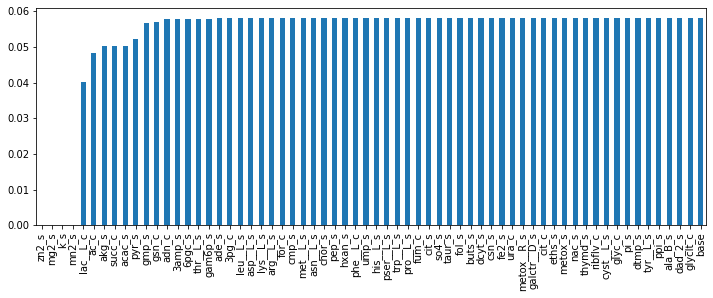

In [112]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))
plt.savefig("group_KO_flux_results_{}.svg".format(version), format="SVG")

In [91]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True)
last_met = sorted_mets.index[list(sorted_mets.index).index(sorted_mets[sorted_mets<1e-5].index[-1])+1]
print(last_met)
flux_dict = flux_results_df[last_met].to_dict() # Last time before model breaks

asn__L_s


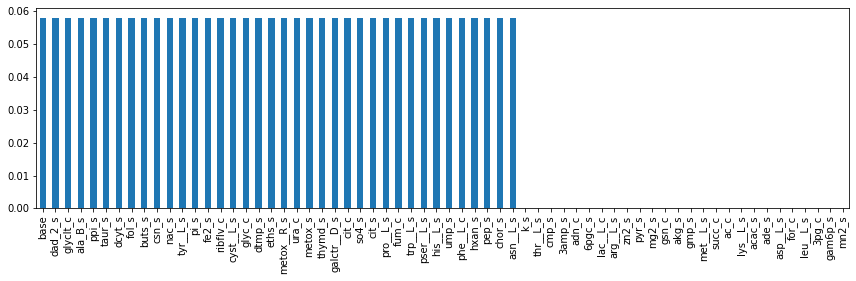

In [92]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets.index[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()
plt.savefig("group_KO_flux_results_{}.svg".format(version), format="SVG")


In [93]:
flux_dict['biomass_dilution']

0.02168148122087299

In [94]:
met='atp_s' # ATP production and glucose uptake
prod_atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
prod_atp_df = prod_atp_df[prod_atp_df['met_flux']>0]
prod_atp_df['met_flux'].sum()

15.866048221386526

In [95]:
prod_atp_df['met_flux'].div(prod_atp_df['met_flux'].sum())

ACKr_REV_BSU29470-MONOMER_s                        0.435925
PGK_REV_BSU33930-MONOMER_s                         0.303972
PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s           0.222772
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s        0.021681
ADK1_REV_BSU01370-MONOMER_mod_mg2_s               0.0152716
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s            0.000229173
URIDK2r_copy2_REV_BSU00280-MONOMER_mod_mg2_s    0.000118324
CYTK2_REV_BSU22890-MONOMER_mod_mg2_s            3.04227e-05
SUCOAS_FWD_CPLX8J2-7_s                          4.18044e-39
LAAL29_FWD_BSU37710-MONOMER_s                   9.05477e-40
PRASCSi_REV_BSU06450-MONOMER_s                   3.6099e-40
ARGKr_REV_CPLX_dummy_s                          1.41334e-40
LAAL23_FWD_BSU37710-MONOMER_s                   1.35944e-40
Name: met_flux, dtype: object

In [120]:
# flux_dict = flux_results_df[last_met].to_dict()
flux_based_reactions(sporeme,'gua_s',flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
GUAPRT_REV_BSU00680-MONOMER_s,0,999999,0.349676,0.349676,gmp_s + ppi_s --> -4.27350427350427e-6*sigma BSU00680-MONOMER_s + gua_s + prpp_s
PUNP3_REV_BSU19630-MONOMER_s,0,999999,0.346841,-0.346841,gua_s + r1p_s --> -4.27350427350427e-6*sigma BSU19630-MONOMER_s + gsn_s + pi_s
PUNP4_REV_BSU19630-MONOMER_s,0,999999,0.00283582,-0.00283582,2dr1p_s + gua_s --> -4.27350427350427e-6*sigma BSU19630-MONOMER_s + dgsn_s + pi_s
GUAt2r_FWD_BSU06370-MONOMER_s,0,0,0,0,gua_c + h_c --> -4.27350427350427e-6*sigma BSU06370-MONOMER_s + gua_s + h_s
PUNP3_FWD_BSU23490-MONOMER_s,0,999999,0,0,gsn_s + pi_s --> -4.27350427350427e-6*sigma BSU23490-MONOMER_s + gua_s + r1p_s
PUNP4_FWD_BSU23490-MONOMER_s,0,999999,0,0,dgsn_s + pi_s --> 2dr1p_s + -4.27350427350427e-6*sigma BSU23490-MONOMER_s + gua_s
GUAt2r_FWD_BSU29990-MONOMER_s,0,0,0,0,gua_c + h_c --> -4.27350427350427e-6*sigma BSU29990-MONOMER_s + gua_s + h_s
PUNP3_REV_BSU23490-MONOMER_s,0,999999,0,-0,gua_s + r1p_s --> -4.27350427350427e-6*sigma BSU23490-MONOMER_s + gsn_s + pi_s
PUNP4_REV_BSU23490-MONOMER_s,0,999999,0,-0,2dr1p_s + gua_s --> -4.27350427350427e-6*sigma BSU23490-MONOMER_s + dgsn_s + pi_s
GUAPRT_FWD_BSU00680-MONOMER_s,0,999999,0,-0,gua_s + prpp_s --> -4.27350427350427e-6*sigma BSU00680-MONOMER_s + gmp_s + ppi_s


In [132]:
flux_dict = flux_results_df['base'].to_dict()
flux_based_reactions(sporeme,'2pg_s',flux_dict=flux_dict,only_types=['MetabolicReaction']).head(10)

,lb,ub,rxn_flux,met_flux,reaction
PGM_REV_BSU33910-MONOMER_mod_mn2_s,0,999999,2.90093,2.90093,3pg_s --> 2pg_s + -2.20620421261451e-6*sigma BSU33910-MONOMER_mod_mn2_s
ENO_FWD_BSU33900-MONOMER_s,0,999999,2.90093,-2.90093,2pg_s --> -2.54380061324535e-6*sigma BSU33900-MONOMER_s + h2o_s + pep_s
ENO_REV_BSU33900-MONOMER_s,0,999999,0,0,h2o_s + pep_s --> 2pg_s + -2.54380061324535e-6*sigma BSU33900-MONOMER_s
2PGt6_FWD_CPLX_dummy_s,0,0,0,0,2pg_c + h_c --> 2pg_s + -4.27350427350427e-6*sigma CPLX_dummy_s + h_s
2PGt6_REV_CPLX_dummy_s,0,0,0,-0,2pg_s + h_s --> 2pg_c + -4.27350427350427e-6*sigma CPLX_dummy_s + h_c
PGM_FWD_BSU33910-MONOMER_mod_mn2_s,0,999999,0,-0,2pg_s --> 3pg_s + -2.20620421261451e-6*sigma BSU33910-MONOMER_mod_mn2_s


### All mechanisms KO

In [97]:
version = 'v5_all_KO'

<AxesSubplot:>

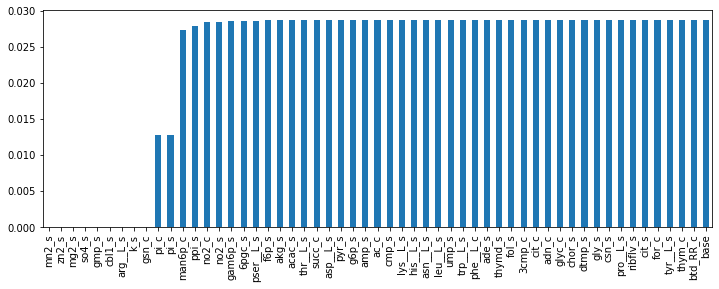

In [83]:
flux_results_df = pd.read_csv('group_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar(figsize=(12 ,4))

In [62]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True)
last_met = sorted_mets.index[list(sorted_mets.index).index(sorted_mets[sorted_mets<1e-5].index[-1])+1]
print(last_met)
flux_dict = flux_results_df[last_met].to_dict() # Last time before model breaks

thr__L_s


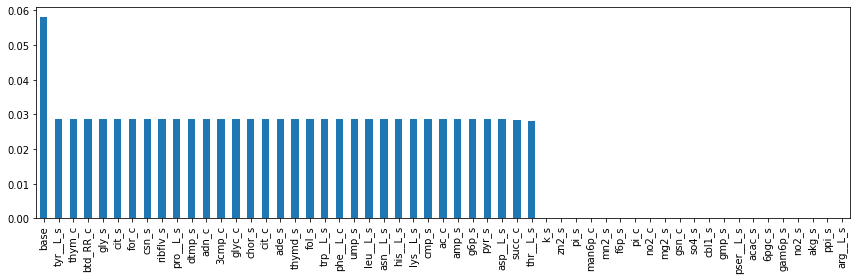

In [63]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_{}.csv'.format(version),index_col=0)
flux_results_df.loc['biomass_dilution_s',sorted_mets.index[::-1]].plot.bar(figsize=(12,4))
plt.tight_layout()

In [64]:
flux_dict['biomass_dilution']

0.011462839961196077

In [65]:
met='atp_s' # ATP production and glucose uptake
prod_atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
prod_atp_df = prod_atp_df[prod_atp_df['met_flux']>0]
prod_atp_df['met_flux'].sum()

24.56360422878673

In [66]:
prod_atp_df['met_flux'].div(prod_atp_df['met_flux'].sum())

PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s        0.500522
ADK1_REV_BSU01370-MONOMER_mod_mg2_s                0.499333
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s            9.02715e-05
URIDK2r_copy2_REV_BSU00280-MONOMER_mod_mg2_s    5.46958e-05
Name: met_flux, dtype: object

In [73]:
flux_based_reactions(sporeme,'nadh_s',flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
ALDD2x_FWD_BSU39860-MONOMER_s,0,999999,0.0696131,0.0696131,acald_s + h2o_s + nad_s --> -4.27350427350427e-6*sigma BSU39860-MONOMER_s + ac_s + 2.0 h_s + nadh_s
G3PD1ir_FWD_BSU22830-MONOMER_s,0,999999,0.0596022,-0.0596022,dhap_s + h_s + nadh_s --> -2.99593631493959e-6*sigma BSU22830-MONOMER_s + glyc3p_s + nad_s
PGCD_REV_CPLX8J2-181_s,0,999999,0.0561937,-0.0561937,3php_s + h_s + nadh_s --> 3pg_s + -4.27350427350427e-6*sigma CPLX8J2-181_s + nad_s
GAPD_FWD_BSU33940-MONOMER_s,0,999999,0.0324539,0.0324539,g3p_s + nad_s + pi_s --> 13dpg_s + -3.09634335676979e-6*sigma BSU33940-MONOMER_s + h_s + nadh_s
GLUDxi_FWD_BSU22960-MONOMER_s,0,999999,0.0172278,0.0172278,glu__L_s + h2o_s + nad_s --> -4.27350427350427e-6*sigma BSU22960-MONOMER_s + akg_s + h_s + nadh_s + nh4_s
...,...,...,...,...,...
ACOAD4_1_FWD_BSU37170-MONOMER_s,0,999999,0,0,dccoa_s + nad_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + dc2coa_s + h_s + nadh_s
XAND_FWD_BSU32510-MONOMER_s,0,999999,0,0,h2o_s + nad_s + xan_s --> -4.27350427350427e-6*sigma BSU32510-MONOMER_s + h_s + nadh_s + urate_s
LLEUDr_REV_BSU24080-MONOMER_s,0,999999,0,-0,4mop_s + h_s + nadh_s + nh4_s --> -4.27350427350427e-6*sigma BSU24080-MONOMER_s + h2o_s + leu__L_s + nad_s
HACD2_REV_BSU32840-MONOMER_s,0,999999,0,0,3hhcoa_s + nad_s --> 3ohcoa_s + -4.27350427350427e-6*sigma BSU32840-MONOMER_s + h_s + nadh_s


In [68]:
flux_based_reactions(sporeme,'prpp_s',flux_dict=flux_dict,only_types=['MetabolicReaction'])

,lb,ub,rxn_flux,met_flux,reaction
GUAPRT_REV_BSU00680-MONOMER_s,0,999999,12.2991,12.2991,gmp_s + ppi_s --> -4.27350427350427e-6*sigma BSU00680-MONOMER_s + gua_s + prpp_s
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s,0,0,12.2946,-12.2946,amp_s + h_s + prpp_s --> -1.38401264312306e-5*sigma BSU00510-MONOMER_mod_mn2_mod_pi_s + atp_s + r5p_s
ORPT_REV_BSU15560-MONOMER_s,0,999999,0.00404941,-0.00404941,orot_s + prpp_s --> -1.86331330653874e-5*sigma BSU15560-MONOMER_s + orot5p_s + ppi_s
ATPPRT_FWD_BSU34920-MONOMER_s,0,999999,0.000298377,-0.000298377,atp_s + prpp_s --> -4.27350427350427e-6*sigma BSU34920-MONOMER_s + ppi_s + prbatp_s
ANPRT_FWD_BSU22670-MONOMER_s,0,999999,0.00012065,-0.00012065,anth_s + prpp_s --> -1.35361847172882e-5*sigma BSU22670-MONOMER_s + ppi_s + pran_s
NNDPR_FWD_BSU27860-MONOMER_mod_mg2_s,0,999999,5.98408e-10,-5.98408e-10,2.0 h_s + prpp_s + quln_s --> -2.4712036904137e-6*sigma BSU27860-MONOMER_mod_mg2_s + co2_s + nicrnt_s + ppi_s
ATPPRT_REV_BSU34920-MONOMER_s,0,999999,0,0,ppi_s + prbatp_s --> -4.27350427350427e-6*sigma BSU34920-MONOMER_s + atp_s + prpp_s
HXPRT_FWD_BSU00680-MONOMER_s,0,999999,0,-0,hxan_s + prpp_s --> -7.37520462238496e-6*sigma BSU00680-MONOMER_s + imp_s + ppi_s
NAPRT_FWD_BSU31750-MONOMER_s,0,999999,0,-0,h_s + nac_s + prpp_s --> -2.68603911285977e-6*sigma BSU31750-MONOMER_s + nicrnt_s + ppi_s
XPPT_FWD_BSU22070-MONOMER_s,0,999999,0,-0,prpp_s + xan_s --> -2.02594348405928e-5*sigma BSU22070-MONOMER_s + ppi_s + xmp_s


In [116]:
sporeme.metabolites.prpp_s.name

'5-Phospho-alpha-D-ribose 1-diphosphate'

In [ ]:
met='atp_s' # ATP production and glucose uptake
atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,growth_symbol='sigma')
atp_df = atp_df[atp_df['met_flux']<0]
atp_df['met_flux'].div(atp_df['met_flux'].sum())

In [50]:
sporeme.reactions.GAM_s.metabolites

{<Metabolite atp_s at 0x7f0636f5e630>: -105.053483,
 <Metabolite h2o_s at 0x7f0636f5e1d0>: -105.053483,
 <Metabolite adp_s at 0x7f0636f5e048>: 105.053483,
 <Metabolite h_s at 0x7f0636f5e5f8>: 105.053483,
 <Metabolite pi_s at 0x7f0636f5e4e0>: 105.053483}

In [61]:
atp_consumption = {}
for r,f in atp_df['met_flux'].items():
    rxn = sporeme.reactions.get_by_id(r)
    if str(type(rxn)) not in atp_consumption: atp_consumption[str(type(rxn))] = 0
    atp_consumption[str(type(rxn))] += f

In [62]:
atp_consumption

{"<class 'cobrame.core.reaction.MetabolicReaction'>": 24.56360422878673}

In [74]:
met='atp_s' # ATP production and glucose uptake
atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
atp_df = atp_df[atp_df['met_flux']>0]

In [75]:
atp_df['met_flux'].div(atp_df['met_flux'].sum())

PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s        0.500522
ADK1_REV_BSU01370-MONOMER_mod_mg2_s                0.499333
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s            9.02715e-05
URIDK2r_copy2_REV_BSU00280-MONOMER_mod_mg2_s    5.46958e-05
Name: met_flux, dtype: object

In [78]:
met='ppi_s' # ATP production and glucose uptake
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'],threshold=0.).head(10)

,lb,ub,rxn_flux,met_flux,reaction
GUAPRT_REV_BSU00680-MONOMER_s,0,999999,12.2991,-12.2991,gmp_s + ppi_s --> -4.27350427350427e-6*sigma BSU00680-MONOMER_s + gua_s + prpp_s
PPIabc_FWD_CPLX_dummy_s,0,999999,12.1354,12.1354,atp_s + h2o_s + ppi_c --> -4.27350427350427e-6*sigma CPLX_dummy_s + adp_s + h_s + pi_s + ppi_s
G3PCT_FWD_BSU35740-MONOMER_s,0,999999,0.0542047,0.0542047,ctp_s + glyc3p_s + h_s --> -4.27350427350427e-6*sigma BSU35740-MONOMER_s + cdpglyc_s + ppi_s
GALUi_FWD_BSU35670-MONOMER_s,0,999999,0.0508184,0.0508184,g1p_s + h_s + utp_s --> -0.000103917016025621*sigma BSU35670-MONOMER_s + ppi_s + udpg_s
UAGDP_FWD_BSU00500-MONOMER_mod_mg2_s,0,999999,0.0127997,0.0127997,acgam1p_s + h_s + utp_s --> -3.37075338803632e-5*sigma BSU00500-MONOMER_mod_mg2_s + ppi_s + uacgam_s
ORPT_REV_BSU15560-MONOMER_s,0,999999,0.00404941,0.00404941,orot_s + prpp_s --> -1.86331330653874e-5*sigma BSU15560-MONOMER_s + orot5p_s + ppi_s
PHCYT_BS_FWD_BSU16540-MONOMER_mod_mg2_mod_k_s,0,999999,0.00325987,0.00325987,0.01 12dag3p_BS_s + ctp_s + h_s --> -1.54262689436083e-5*sigma BSU16540-MONOMER_mod_mg2_mod_k_s + 0.01 cdpdag_BS_s + ppi_s
FACOAL150_anteiso_FWD_BSU10360-MONOMER_s,0,999999,0.0030704,0.0030704,atp_s + coa_s + fa4_s --> -4.27350427350427e-6*sigma BSU10360-MONOMER_s + amp_s + fa4coa_s + ppi_s
TECA2S45_FWD_CPLX000-66_s,0,999999,6.61455e-05,0.00297655,45.0 ala__D_s + 45.0 atp_s + 45.0 cdpglyc_s + 45.0 h2o_s + uacgam_s + uacmam_s --> -4.27350427350427e-6*sigma CPLX000-66_s + 45.0 amp_s + 45.0 cmp_s + gtca2_45_BS_s + 91.0 h_s + 45.0 ppi_s + udp_s + ump_s
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s,0,999999,0.00221739,-0.00221739,amp_s + argsuc_s + h_s + ppi_s --> -4.27350427350427e-6*sigma BSU29450-MONOMER_mod_mg2_s + asp__L_s + atp_s + citr__L_s


In [43]:
met='g3p_s' # ATP production and glucose uptake
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).head(10)

,lb,ub,rxn_flux,met_flux,reaction
GAPD_FWD_BSU33940-MONOMER_s,0,999999,4.82284,-4.82284,g3p_s + nad_s + pi_s --> 13dpg_s + -3.09634335676979e-6*sigma BSU33940-MONOMER_s + h_s + nadh_s
TPI_FWD_BSU33920-MONOMER_s,0,999999,4.81724,4.81724,dhap_s --> -3.82588298571337e-6*sigma BSU33920-MONOMER_s + g3p_s
TKT1_FWD_BSU17890-MONOMER_mod_mg2_mod_mn2_mod_thmpp_s,0,999999,0.0172825,0.0172825,r5p_s + xu5p__D_s --> -4.27350427350427e-6*sigma BSU17890-MONOMER_mod_mg2_mod_mn2_mod_thmpp_s + g3p_s + s7p_s
TALA_FWD_CPLX8J2-126_s,0,999999,0.0172825,-0.0172825,g3p_s + s7p_s --> -6.70308015237875e-7*sigma CPLX8J2-126_s + e4p_s + f6p_s
TKT2_FWD_BSU17890-MONOMER_mod_mg2_mod_mn2_mod_thmpp_s,0,999999,0.0109346,0.0109346,e4p_s + xu5p__D_s --> -1.08473043261878e-6*sigma BSU17890-MONOMER_mod_mg2_mod_mn2_mod_thmpp_s + f6p_s + g3p_s
DRPA_REV_BSU39420-MONOMER_s,0,999999,0.00594608,-0.00594608,acald_s + g3p_s --> 2dr5p_s + -1.87911930275808e-5*sigma BSU39420-MONOMER_s
TRPS1_FWD_CPLX8J2-19_mod_pydx5p_s,0,999999,0.000667339,0.000667339,3ig3p_s + ser__L_s --> -4.73113259594653e-6*sigma CPLX8J2-19_mod_pydx5p_s + g3p_s + h2o_s + trp__L_s
DXPS_FWD_BSU24270-MONOMER_mod_thmpp_s,0,999999,0.000107636,-0.000107636,g3p_s + h_s + pyr_s --> -1.11685525170979e-6*sigma BSU24270-MONOMER_mod_thmpp_s + co2_s + dxyl5p_s
FBA_FWD_BSU37120-MONOMER_s,0,999999,4.25064e-05,4.25064e-05,fdp_s --> -3.5030386613539e-6*sigma BSU37120-MONOMER_s + dhap_s + g3p_s
EDA_FWD_BSU22100-MONOMER_s,0,999999,0,0,2ddg6p_s --> -4.64479094452713e-6*sigma BSU22100-MONOMER_s + g3p_s + pyr_s


In [ ]:
met='hom__L_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).head(10)

In [ ]:
sporeme.metabolites.get_by_id('gam1p_c').name

In [ ]:
met='orn__L_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).head(10)

In [ ]:
met='h_c' # ATP production and glucose uptake
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
met='3amp_s' # ATP production and glucose uptake
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
met='pyr_s' # ATP production and glucose uptake
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='pep_s' # ATP production and glucose uptake
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='cit_s'
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='met__L_s' # Protein synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
met='so4_s' # Protein synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
met='arg__L_s' # Ornithine synthesis, ArgSuc synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='argsuc_s' # Citruline synthesis.  Urea cycle and the synthesis of pyrimidines: nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='glu5sa_s' # Citruline synthesis.  Urea cycle and the synthesis of pyrimidines: nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
sporeme.reactions.get_by_id('G5SADs_FWD_CPLX_dummy_s').reaction

In [ ]:
met='citr__L_s' # Carbamoyl phosphate and ornithine synthesis.  Urea cycle and the synthesis of pyrimidines: nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='pser__L_s' # Glutamate synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='asp__L_s' # Production of 4asp
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='gdp_s' # Nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
sporeme.reactions.get_by_id('ADSS_FWD_BSU40420-MONOMER_s').reaction

In [ ]:
met='gtp_s' # Nucleotide synthesis
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
met='acnam_s' # A fraction of PEP_s requirement in the spore
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='3amp_s' # Pumping phosporus Pi C->S. Pi is used to pump Fructose C->S
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='f6p_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='man6p_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='h_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='pi_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])

In [ ]:
sporeme.reactions.get_by_id('3AMPt6_FWD_CPLX_dummy_s').reaction

In [ ]:
sporeme.reactions.get_by_id('3NUCLE1_FWD_BSU07840-MONOMER_s').reaction

In [ ]:
sporeme.reactions.get_by_id('ADNt2_REV_BSU38710-MONOMER_s').reaction

In [ ]:
sporeme.reactions.get_by_id('3NUCLE1_REV_BSU07840-MONOMER').reaction

In [ ]:
sporeme.metabolites.get_by_id('so4_s').name

In [ ]:
met='adn_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='pi_s' #
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='leu__L_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='glu__L_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [ ]:
met='orn__L_s' # 
flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction']).to_csv('metabolite_cases/{}.csv'.format(met[:-2]))

In [170]:
met='atp_s' # ATP production and glucose uptake
prod_atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,only_types=['MetabolicReaction'])
prod_atp_df = prod_atp_df[prod_atp_df['met_flux']>0]
prod_atp_df['met_flux'].sum()

15.866048221386526

In [19]:
prod_atp_df['met_flux'].div(prod_atp_df['met_flux'].sum())

ACKr_REV_BSU29470-MONOMER_s                        0.435925
PGK_REV_BSU33930-MONOMER_s                         0.303972
PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s           0.222772
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s        0.021681
ADK1_REV_BSU01370-MONOMER_mod_mg2_s               0.0152716
ARGSS_REV_BSU29450-MONOMER_mod_mg2_s            0.000229173
URIDK2r_copy2_REV_BSU00280-MONOMER_mod_mg2_s    0.000118324
CYTK2_REV_BSU22890-MONOMER_mod_mg2_s            3.04227e-05
SUCOAS_FWD_CPLX8J2-7_s                          4.18044e-39
LAAL29_FWD_BSU37710-MONOMER_s                   9.05477e-40
PRASCSi_REV_BSU06450-MONOMER_s                   3.6099e-40
ARGKr_REV_CPLX_dummy_s                          1.41334e-40
LAAL23_FWD_BSU37710-MONOMER_s                   1.35944e-40
Name: met_flux, dtype: object

In [167]:
met='atp_s' # ATP production and glucose uptake
atp_df = flux_based_reactions(sporeme,met,flux_dict=flux_dict,growth_symbol='sigma')
atp_df = atp_df[atp_df['met_flux']<0]
atp_df['met_flux'].div(atp_df['met_flux'].sum())

ATPM_s                                      0.56712
GAM_s                                      0.382665
NDPK1_FWD_BSU22730-MONOMER_mod_mn2_s     0.00931769
NDPK2_FWD_BSU22730-MONOMER_mod_mn2_s     0.00753493
CYTK1_FWD_BSU22890-MONOMER_mod_mg2_s     0.00699603
                                           ...     
transcription_TU_BSU_rRNA_18_s          1.00652e-40
LAAL33_FWD_BSU37710-MONOMER_s           7.95121e-41
translation_BSU30740_s                  1.77329e-44
translocation_BSU30770_s                2.87636e-45
translocation_BSU30760_s                1.79263e-45
Name: met_flux, Length: 831, dtype: object

In [186]:
sporeme.reactions.GAM_s.metabolites

{<Metabolite atp_s at 0x7f3a26ba8550>: -105.053483,
 <Metabolite h2o_s at 0x7f3a26ba85f8>: -105.053483,
 <Metabolite adp_s at 0x7f3a26ba8710>: 105.053483,
 <Metabolite h_s at 0x7f3a26ba8898>: 105.053483,
 <Metabolite pi_s at 0x7f3a26ba87b8>: 105.053483}

In [180]:
atp_consumption = {}
for r,f in atp_df['met_flux'].items():
    rxn = sporeme.reactions.get_by_id(r)
    if str(type(rxn)) not in atp_consumption: atp_consumption[str(type(rxn))] = 0
    
    atp_consumption[str(type(rxn))] += f

## Essential mets

In [ ]:
with open("./sporeme_solution_v4_CYTK2.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [44]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results_v4.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True)
essential_mets = list(sorted_mets.iloc[:list(sorted_mets.index).index(sorted_mets[sorted_mets<1e-5].index[-1])+2].index) # All up until the last one before it breaks 
print('Essential metabolites: {}'.format(essential_mets))

Essential metabolites: ['mn2_s', 'gam6p_s', '3pg_c', 'leu__L_s', 'for_c', 'asp__L_s', 'ade_s', 'acac_s', 'lys__L_s', 'ac_c', 'succ_c', 'met__L_s', 'gmp_s', 'akg_s', 'gsn_c', 'mg2_s', 'pyr_s', 'zn2_s', 'arg__L_s', 'lac__L_c', '6pgc_s', 'adn_c', '3amp_s', 'cmp_s', 'thr__L_s', 'k_s', 'asn__L_s']


In [45]:
essential_transporters = []
for met in essential_mets:
    [essential_transporters.append(i) for i in at_dict[met]]

In [46]:
print('{} essential open transporters'.format(len(essential_transporters)))

72 essential open transporters


In [47]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [48]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 251.814851 seconds
Finished substituting S,lb,ub in 7.384463 seconds
Finished makeME_LP in 1.557973 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.075 0.075 1
Finished substituting S,lb,ub in 7.411553 seconds
Finished makeME_LP in 1.542169 seconds
Getting MINOS parameters from ME_NLP...
2 0.0375 0.0375 0.075 0.0375 optimal
Finished substituting S,lb,ub in 7.410092 seconds
Finished makeME_LP in 1.562008 seconds
Getting MINOS parameters from ME_NLP...
3 0.056249999999999994 0.056249999999999994 0.075 0.056249999999999994 optimal
Finished substituting S,lb,ub in 7.202686 seconds
Finished makeME_LP in 1.550135 seconds
Getting MINOS parameters from ME_NLP...
4 0.056249999999999994 0.056249999999999994 0.06562499999999999 0.06562499999999999 1
Finished substituting S,lb,ub in 7.194803 seconds
Finished makeME_LP in 1.555077 seconds
Getting MINOS parameters from ME_NLP...
5 0.056249999999999994 0.05624

In [49]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_mets, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
flux_results_df.to_csv('essential_metabolite_group_KO_v4.csv')

Chosen change function: group_knockout      Sequential = False


biomass_dilution_s response (20 threads): 100%|██████████| 27/27 [2:08:29<00:00, 285.54s/it]   


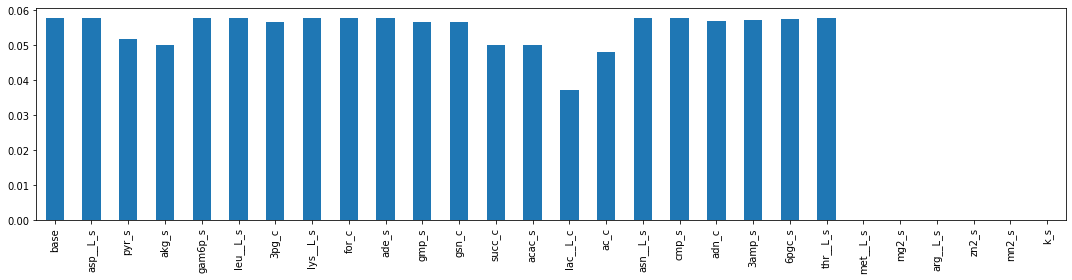

In [50]:
flux_results_df = pd.read_csv('essential_metabolite_group_KO_v4.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))
plt.tight_layout()
plt.savefig("essential_metabolite_group_KO_v4.svg", format="SVG")

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,essential_transporters, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('essential_transporter_KO_v4.csv')

Process ForkPoolWorker-55:
Traceback (most recent call last):
  File "/opt/python3.6.8/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/python3.6.8/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/python3.6.8/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/jt/UCSD/bacillusme-master/bacillusme/analysis/sensitivity.py", line 104, in single_flux_response
    solve_model(me,precision = precision,mu_fix=mu_fix,growth_key=growth_key)
  File "/home/jt/UCSD/bacillusme-master/bacillusme/analysis/sensitivity.py", line 115, in solve_model
    verbosity=0,growth_key=growth_key)
  File "/home/jt/UCSD/bacillusme-master/bacillusme/util/helper_functions.py", line 298, in solve_me_model
    muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu, verbosity=verbosity)
  File "/home/jt/UCSD/solvemepy-master

In [ ]:
flux_results_df = pd.read_csv('essential_transporter_KO_v4.csv',index_col=0)
flux_results_df.loc['biomass_dilution_s'].plot.bar(figsize=(15,4))

In [ ]:
# flux_results_df.loc['biomass_dilution_s',at_dict['arg__L_s']+at_dict['met__L_c']].plot.bar()

In [ ]:
# for r in at_dict['arg__L_s']:
#     rxn = sporeme.reactions.get_by_id(r)
#     print(rxn.reaction)

### Network visualization

In [ ]:
import itertools
import networkx as nx

In [ ]:
flux_results_df = pd.read_csv('essential_transporter_KO_v4.csv',index_col=0)

In [ ]:
flux_results_df.drop('base',axis=1)

In [ ]:
G = nx.Graph()

for r in essential_transporters:
    rxn = sporeme.reactions.get_by_id(r)
    mets = list(set([m.id[:-2] for m in rxn.metabolites if isinstance(m,cobrame.Metabolite)]))
    combinations = list(itertools.combinations(mets, 2))
    
    for m in mets:
        G.add_node(m,node_size=1000)
    
    for c in combinations:
        G.add_edge(c[0],c[1])

In [ ]:
print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

In [ ]:
d = dict(G.degree)

pos = nx.spring_layout(G)
plt.figure(figsize=(13,8))
nx.draw(G,pos=pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()],alpha=0.8)

for label in pos.keys():
    x,y = pos[label]
    plt.text(x,y+0.09,s=label,horizontalalignment='center')

plt.draw()
plt.savefig("transport_graph_v4.svg", format="SVG")

# Backup of previous analyses

In [39]:
# flux_dict = {}
# b = 0
# for met in tqdm(sorted_mets):
#     transport = at_dict[met]
    
#     if b == 1:
#         flux_dict[met] = {r.id:0. for r in sporeme.reactions}
#         continue
    
#     for r in transport:
#         rxn = sporeme.reactions.get_by_id(r)
#         rxn.lower_bound = 0
#         rxn.upper_bound = 0
#     solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-4,growth_key = 'sigma',
#                   verbosity = 0)
#     if sporeme.solution:
#         flux_dict[met] = sporeme.solution.x_dict
#     else:
#         flux_dict[met] = {r.id:0. for r in sporeme.reactions}
#         b = 1
# flux_results_df = pd.DataFrame.from_dict(flux_dict)


## Single KO

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,active_transporters, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('comm_transport_flux_results.csv')

In [ ]:
# All of them:
flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0)
(n, bins, patches) = plt.hist(flux_results_df.loc['biomass_dilution_s'])
plt.xlabel('Growth rate')
plt.ylabel('Counts')

In [ ]:
transport_dict = {}
for candidate in flux_results_df.drop('base',axis=1).columns:
    r = sporeme.reactions.get_by_id(candidate)
    mets = []
    [mets.append(re.split('_.$',m.id)[0]) for m in r.metabolites if isinstance(m,cobrame.Metabolite) and 'h_' not in m.id]
    mets = list(set(mets))
    transport_dict[candidate] = mets[0]
    
plt.figure(figsize=(13,3))
flux_results_df.loc['biomass_dilution_s'].sort_values().plot.bar()
plt.xlabel('Single knockout')
plt.ylabel('Spore growth rate')

In [ ]:
# Important transporters without gene so far
df = flux_results_df.loc['biomass_dilution_s'].sort_values().head(20)
df[df.index.str.contains('dummy')]

In [ ]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cluster_df = cluster_df.loc[:,output.loc['biomass_dilution_s']<bins[-1]]
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

Identify essential transporters so far. These are stored and taken out as they are already results.

In [ ]:
essential_transporters = list(output.columns[output.loc['biomass_dilution_s'] < 0.001])
non_essential_transporter = list(output.columns[output.loc['biomass_dilution_s'] >= bins[-1]])

# Remove non-essential
candidates_df = output.drop(non_essential_transporter,axis=1)
# Remove the ones that we now already are essential
candidates_df = candidates_df.drop(essential_transporters,axis=1)

print('{} transporters are obviously non-essential: {} \n'.format(len(non_essential_transporter),non_essential_transporter))
print('So far, {} transporters are obviously essential: {} \n'.format(len(essential_transporters),essential_transporters))

print('There are {} candidates: {} \n'.format(len(candidates_df.columns),candidates_df.columns.values))

In [ ]:
# The rest:
(n, bins, patches) = plt.hist(candidates_df.loc['biomass_dilution_s'])
plt.xlabel('Growth rate')
plt.ylabel('Counts')

In [ ]:
output = candidates_df.loc[candidates_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cm = sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako",yticklabels=1,xticklabels=1)

plt.savefig('clustermap_filtered')

In [ ]:
# 1. Pairwise interaction knockout
# 2. Find minimal set of transporters. Sort values and close less essential first. 
# Ignore those transporters that are not active. Restore them if they are turned on again to compensate.
# 3. Do these simulations change with different NGAM?

## Pairwise interaction

In [ ]:
from bacillusme.analysis import sensitivity as ss
transport_reactions_filtered = cluster_df.columns.values
base_model = copy.deepcopy(sporeme)

In [ ]:
from scipy.special import binom
print('With {} knockouts there can be {} pairs'.format(len(transport_reactions_filtered),binom(len(transport_reactions_filtered),2)))

In [ ]:
for r in transport_reactions_filtered:
    # Restore
    sporeme = copy.deepcopy(base_model)
    
    # Close transporter
    rxn = sporeme.reactions.get_by_id(r)
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    
    # Calculation
    flux_results_df = ss.transporter_knockout(sporeme,transport_reactions_filtered, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
    flux_results_df.to_csv('transporter_knockouts/{}.csv'.format(r))

In [ ]:
# Read and process
gr_df = pd.DataFrame(index=transport_reactions_filtered)
for r in transport_reactions_filtered:
    flux_results_df=pd.read_csv('transporter_knockouts/{}.csv'.format(r),index_col=0).drop('base',axis=1)
    for i in transport_reactions_filtered:
        gr_df.loc[r,i] = flux_results_df.loc['biomass_dilution_s',i]

In [ ]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)].drop('H2Ot_FWD_CPLX_dummy_s',axis=0).drop('H2Ot_FWD_CPLX_dummy_s',axis=1)
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(output,col_cluster=1,row_cluster=1, cmap='mako')
plt.savefig('pairwise_growth')

## Check for other possible transporters

Close each one of the active 51 transporters and check for all other transporters that might turn on. Then include all in the analysis.

In [ ]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
closed_flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0).drop('base',axis=1)

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,active_transporters, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('single_ko_all_open.csv')

In [ ]:
flux_results_df = pd.read_csv('single_ko_all_open.csv',index_col=0)

In [ ]:
new_transporters = []
for r in transport_reactions:
    if (flux_results_df.loc[r]>0).any() and r not in active_transporters:
        new_transporters.append(r)
        
        print('REACTION:',r,flux_results_df.loc[r,'base'])
        print(flux_results_df[flux_results_df.columns[flux_results_df.loc[r]>0]].loc[r])
        print('\n')

In [ ]:
include_transporters = new_transporters
output = flux_results_df.loc[include_transporters,active_transporters]

In [ ]:
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako',yticklabels=1,xticklabels=1,figsize=(13,13))
plt.savefig('transporters_turned_on')

### Mini robustness

In [ ]:
transport_reactions = ['ASPt2r_FWD_CPLX_dummy_s','4FE4St_s','PSER_Lt6_FWD_CPLX_dummy_s','CBL1t_s']

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,transport_reactions, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',overexpress=True)
flux_results_df.to_csv('overexpress_flux_results.csv')

In [ ]:
flux_results_df = pd.read_csv('overexpress_flux_results.csv',index_col=0)

In [ ]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

In [ ]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

#### Pairwise interaction

In [96]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [97]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [98]:
flux_results_df = pd.read_csv('essential_metabolite_group_KO.csv',index_col=0)
essential_metabolites = flux_results_df.drop('base',axis=1).columns.values
base_model = copy.deepcopy(sporeme)

In [99]:
from scipy.special import binom
print('With {} knockouts there can be {} pairs'.format(len(essential_metabolites),binom(len(essential_metabolites),2)))

With 21 knockouts there can be 210.0 pairs


In [ ]:
from bacillusme.analysis import sensitivity as ss
for met in essential_metabolites:
    # Restore
    sporeme = copy.deepcopy(base_model)
    
    # Close transporter
    for r in at_dict[met]:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.lower_bound = 0
        rxn.upper_bound = 0
    
    # Calculation
    flux_results_df = ss.transporter_knockout(sporeme,essential_metabolites, \
                                        NP=20,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='group_knockout')
    flux_results_df.to_csv('group_transporter_knockouts/{}.csv'.format(met))

Chosen change function: group_knockout      Sequential = False
























  0%|          | 0/21 [00:00<?, ?it/s]





















biomass_dilution_s response (20 threads):   0%|          | 0/21 [00:00<?, ?it/s]

In [102]:
flux_results_df

,base,arg__L_s,zn2_s,so4_s,acnam_s,pser__L_s,6pgc_s,asp__L_s,k_s,gmp_s,...,pyr_c,cbl1_s,mg2_s,pi_c,3amp_s,adn_c,man6p_c,mn2_s,f6p_s,met__L_c
biomass_dilution,0.046832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
protein_biomass_to_biomass,0.026954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mRNA_biomass_to_biomass,0.000092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tRNA_biomass_to_biomass,0.000544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rRNA_biomass_to_biomass,0.004027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demand_psetha_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_t12dg_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_gtca3_45_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Demand_lipo1_24_BS_s,0.112613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Read and process
gr_df = pd.DataFrame(index=essential_metabolites)
for m in essential_metabolites:
    flux_results_df=pd.read_csv('group_transporter_knockouts/{}.csv'.format(m),index_col=0).drop('base',axis=1)
    for i in flux_results_df.columns.values:
        gr_df.loc[m,i] = flux_results_df.loc['biomass_dilution_s',i]

<Figure size 936x360 with 0 Axes>

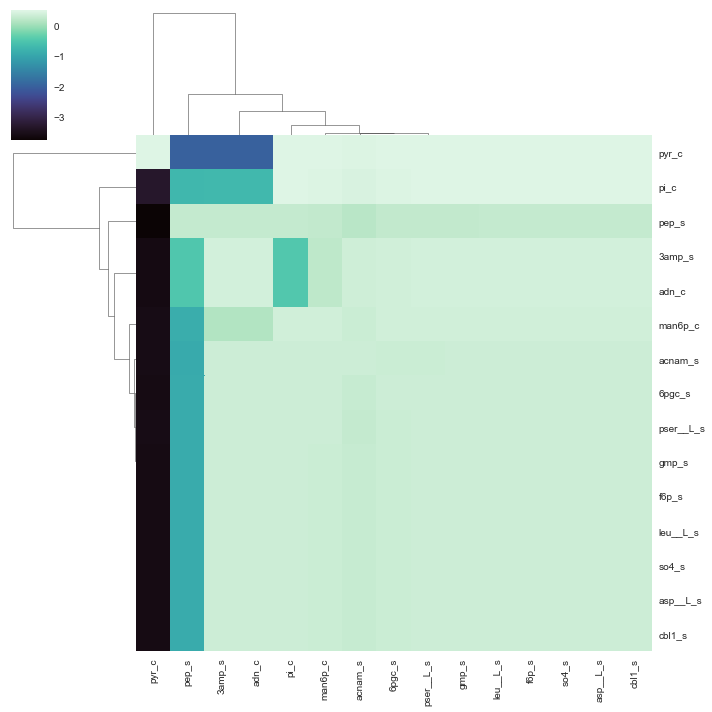

In [105]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)]
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako')

<Figure size 936x360 with 0 Axes>

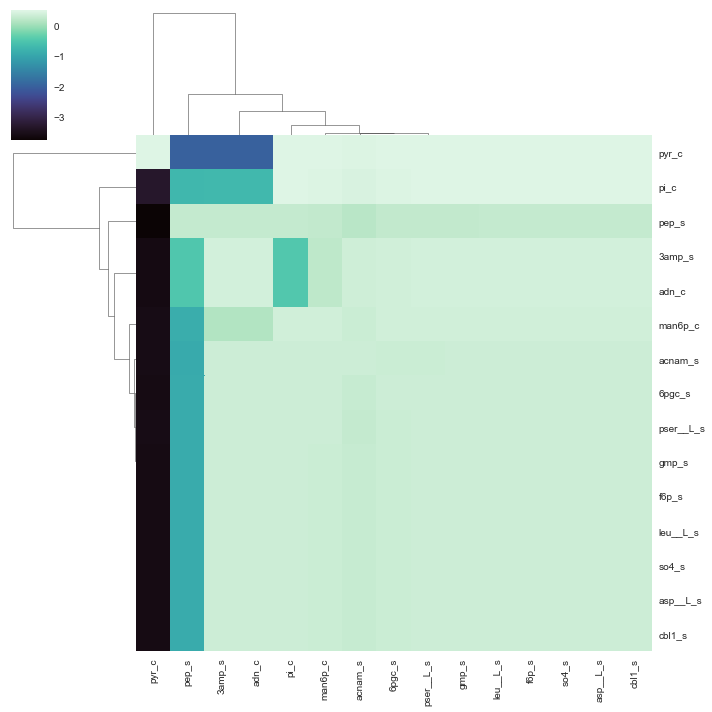

In [111]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)]
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1, cmap='mako')

## Energy analysis

In [188]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [189]:
flux_results_df = pd.read_csv('group_1by1_KO_flux_results.csv',index_col=0)
sorted_mets = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=True).index.to_list()
essential_mets = sorted_mets[:sorted_mets.index('met__L_c')+1]
print('Essential metabolites: {}'.format(essential_mets))

Essential metabolites: ['arg__L_s', 'zn2_s', '6pgc_s', 'so4_s', 'mg2_s', 'pi_c', 'cbl1_s', 'asp__L_s', 'f6p_s', 'mn2_s', 'adn_c', 'acnam_s', 'pep_s', 'pyr_c', 'k_s', 'pser__L_s', 'man6p_c', 'gmp_s', 'leu__L_s', '3amp_s', 'met__L_c']


In [190]:
essential_transporters = []
for met in essential_mets:
    [essential_transporters.append(i) for i in at_dict[met]]

In [191]:
print('{} essential open transporters'.format(len(essential_transporters)))

63 essential open transporters


In [192]:
for r in transport_reactions:
    if r not in essential_transporters and 'SPONT' not in r:
        rxn = sporeme.reactions.get_by_id(r)
        rxn.upper_bound = 0 
        rxn.lower_bound = 0

In [ ]:
solve_me_model(sporeme, max_mu = 0.15, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')
flux_dict_base = sporeme.solution.x_dict

iter	muopt    	a     	b     	mu1       	stat1


### Increasing ATPM

In [ ]:
current_ATPM = sporeme.reactions.ATPM_s.lower_bound
new_ATPM = 1.1 * current_ATPM

sporeme.reactions.ATPM_s.lower_bound = new_ATPM
sporeme.reactions.ATPM_s.upper_bound = new_ATPM

In [177]:
solve_me_model(sporeme, max_mu = 0.2, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key='sigma')
flux_dict_ATPM = sporeme.solution.x_dict

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 415.296403 seconds
Finished substituting S,lb,ub in 18.126293 seconds
Finished makeME_LP in 2.265234 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.1 0.1 1
Finished substituting S,lb,ub in 18.146298 seconds
Finished makeME_LP in 2.297373 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 18.020615 seconds
Finished makeME_LP in 2.269276 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.025 0.025 1
Finished substituting S,lb,ub in 17.943079 seconds
Finished makeME_LP in 2.261524 seconds
Getting MINOS parameters from ME_NLP...
4 0.0125 0.0125 0.025 0.0125 optimal
Finished substituting S,lb,ub in 17.930481 seconds
Finished makeME_LP in 2.260695 seconds
Getting MINOS parameters from ME_NLP...
5 0.0125 0.0125 0.018750000000000003 0.018750000000000003 1
Finished substituting S,lb,ub in 18.196980 seconds
Finished makeME_LP in 2.283978 second

In [199]:
atp_df = pd.DataFrame.from_dict({'flux':flux_dict_base}).join(pd.DataFrame.from_dict({'flux':flux_dict_ATPM}),rsuffix='_atp')
atp_df.loc['ATPM_s']

flux        11.979
flux_atp     9.900
Name: ATPM_s, dtype: float64

In [215]:
sums = atp_df.loc[at_dict[met]].sum(axis=0)
sums.any()

True

## 

In [218]:

for met in at_dict.keys():
    sums = atp_df.loc[at_dict[met]].sum(axis=0)
    if sums.any():
        ratio = sums['flux_atp']/sums['flux']
        print(met,ratio)

mg2_s 1.369556359552247
gmp_s 1.3936761015209471
pyr_c 0.9235568354626225
k_s 1.402986049062581
man6p_c 1.4041387607925155
arg__L_s 1.3820070949439316
met__L_c 1.3367661897406746
mn2_s 1.3274067919517458
acnam_s 1.410649664782645
pep_s 0.9219755938517683
so4_s 1.3508168559868865
zn2_s 1.9776180944903203
adn_c 0.9206735465435527
3amp_s 0.9206362189827443
pser__L_s 1.431980366328135
6pgc_s 1.404908804372569
leu__L_s 1.3894840437357847


## Metabolites in medium

In [ ]:
[fed_mets = m for m in at_dict.keys() if m]

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,fed_mets, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',single_change_function='feed_metabolites')

Chosen change function: feed_metabolites      Sequential = False














































  0%|          | 0/38 [00:00<?, ?it/s]











































biomass_dilution_s response (10 threads):   0%|          | 0/38 [00:00<?, ?it/s]

In [225]:
flux_results_df

,base,gly_s,nac_s,cit_s,amp_s,citr__L_s,asn__L_s,acac_s,cmp_s,ump_s,...,ala__D_s,glu__L_s,pnto__R_s,dad_2_s,ribflv_s,3amp_s,ala__L_s,6pgc_s,pser__L_s,leu__L_s
biomass_dilution,0.012078,0.012073,0.012052,0.012060,0.012035,0.012056,0.012061,0.012064,0.012043,0.012044,...,0.012067,0.012055,0.012034,0.012034,0.011992,0.012036,0.012067,0.012054,0.012067,0.012050
protein_biomass_to_biomass,0.007074,0.007072,0.007059,0.007064,0.007049,0.007061,0.007065,0.007066,0.007054,0.007055,...,0.007068,0.007061,0.007049,0.007049,0.007024,0.007050,0.007068,0.007060,0.007068,0.007058
mRNA_biomass_to_biomass,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,...,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020,0.000020
tRNA_biomass_to_biomass,0.000119,0.000119,0.000119,0.000119,0.000118,0.000119,0.000119,0.000119,0.000118,0.000118,...,0.000119,0.000119,0.000118,0.000118,0.000118,0.000118,0.000119,0.000119,0.000119,0.000119
rRNA_biomass_to_biomass,0.000879,0.000879,0.000877,0.000878,0.000876,0.000877,0.000878,0.000878,0.000876,0.000876,...,0.000878,0.000877,0.000876,0.000876,0.000872,0.000876,0.000878,0.000877,0.000878,0.000877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demand_t12dg_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_gtca3_45_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_lipo1_24_BS_s,0.030711,0.030701,0.030658,0.030674,0.030608,0.030663,0.030672,0.030684,0.030635,0.030640,...,0.030691,0.030657,0.030620,0.030610,0.030513,0.030612,0.030691,0.030661,0.030687,0.030656
Demand_tcam_BS_s,0.539554,0.539392,0.538664,0.538933,0.537795,0.538743,0.538900,0.539076,0.538259,0.538332,...,0.539224,0.538640,0.537977,0.537838,0.536119,0.537875,0.539226,0.538711,0.539156,0.538619
